In [1]:
import pandas as pd
import numpy as np


# for Modelling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

from tensorflow.keras.models import load_model

# for Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

# Import required library
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
df= pd.read_csv('bx_t1.csv')
df

,Time id,Material,Quantity,Total_Value,Material_Id
0,1,C01-100100,4.0,11560.00,108
1,1,C06-501311,31.0,36731.17,719
2,1,C06-700217,2.0,25900.00,797
3,1,C07-500328,22.0,44702.25,884
4,1,C37-000235,7.0,23828.07,1663
...,...,...,...,...,...
890,38,S12-160336,3.0,39648.85,14447
891,38,S12-160337,3.0,45048.86,14448
892,38,S23-100109,13.0,71666.86,8594
893,38,S31-020101,317.0,65936.00,9207


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to build and train RNN models
def build_and_train_model(model_type, X_train, y_train):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    return model

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize an empty DataFrame to store the forecast results
forecast_df = pd.DataFrame(columns=['Time id', 'Material id', 'Model', 'Actual Quantity', 'Forecasted', 'MAE', 'MAPE', 'R2'])

# Iterate over each material id
for material_id in df['Material_Id'].unique():
    print(f"Forecasting for Material ID: {material_id}")

    # Filter data for the current material id
    material_data = df[df['Material_Id'] == material_id]

    # Split data into train and test sets
    train = material_data[(material_data['Time id'] >= 13) & (material_data['Time id'] <= 27)]
    test = material_data[material_data['Time id'] == 28]

    # Check if both train and test sets have at least one sample
    if len(train) == 0 or len(test) == 0:
        print(f"Skipping Material ID: {material_id} due to empty train or test set.")
        continue

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[['Quantity']])
    test_scaled = scaler.transform(test[['Quantity']])

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(train_scaled, (train_scaled.shape[0], 1, 1))
    X_test = np.reshape(test_scaled, (test_scaled.shape[0], 1, 1))
    y_train = train_scaled[:, 0]  # Target variable is Quantity

    # Iterate over each model type
    for model_type in ['SimpleRNN', 'GRU', 'LSTM']:
        print(f"Forecasting with {model_type} model for Material ID: {material_id}")

        # Build and train model
        model = build_and_train_model(model_type, X_train, y_train)

        # Forecast for the test set
        forecasted_values = model.predict(X_test)
        forecasted_values_inv = scaler.inverse_transform(forecasted_values)

        # Get actual quantity for the test set
        actual_quantity = test['Quantity'].values[0]

        # Calculate MAE and MAPE
        mae = mean_absolute_error([actual_quantity], forecasted_values_inv[0])
        mape = mean_absolute_percentage_error([actual_quantity], forecasted_values_inv[0])

        # Calculate R²
        mse = mean_squared_error([actual_quantity], forecasted_values_inv[0])
        r2 = 1 - (mse / (actual_quantity ** 2))  # Simplified R² calculation

        # Append results to the dataframe
        forecast_df = forecast_df.append({
            'Time id': 28,
            'Material id': material_id,
            'Model': model_type,
            'Actual Quantity': actual_quantity,
            'Forecasted': forecasted_values_inv[0][0],
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }, ignore_index=True)

# Display the forecast results dataframe
print(forecast_df)


Forecasting for Material ID: 108
Forecasting with SimpleRNN model for Material ID: 108


C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Forecasting with GRU model for Material ID: 108


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Forecasting with LSTM model for Material ID: 108


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Forecasting for Material ID: 719
Forecasting with SimpleRNN model for Material ID: 719


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Forecasting with GRU model for Material ID: 719


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Forecasting with LSTM model for Material ID: 719


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Forecasting for Material ID: 797
Forecasting with SimpleRNN model for Material ID: 797


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Forecasting with GRU model for Material ID: 797


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Forecasting with LSTM model for Material ID: 797


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Forecasting for Material ID: 884
Forecasting with SimpleRNN model for Material ID: 884


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Forecasting with GRU model for Material ID: 884


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Forecasting with LSTM model for Material ID: 884


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Forecasting for Material ID: 1663
Forecasting with SimpleRNN model for Material ID: 1663


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Forecasting with GRU model for Material ID: 1663


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Forecasting with LSTM model for Material ID: 1663


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Forecasting for Material ID: 1664
Forecasting with SimpleRNN model for Material ID: 1664


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Forecasting with GRU model for Material ID: 1664


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Forecasting with LSTM model for Material ID: 1664


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Forecasting for Material ID: 1692
Skipping Material ID: 1692 due to empty train or test set.
Forecasting for Material ID: 1715
Forecasting with SimpleRNN model for Material ID: 1715


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Forecasting with GRU model for Material ID: 1715


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Forecasting with LSTM model for Material ID: 1715


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Forecasting for Material ID: 1716
Forecasting with SimpleRNN model for Material ID: 1716


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Forecasting with GRU model for Material ID: 1716


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Forecasting with LSTM model for Material ID: 1716


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Forecasting for Material ID: 1732
Skipping Material ID: 1732 due to empty train or test set.
Forecasting for Material ID: 2600
Skipping Material ID: 2600 due to empty train or test set.
Forecasting for Material ID: 2865
Forecasting with SimpleRNN model for Material ID: 2865


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Forecasting with GRU model for Material ID: 2865


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Forecasting with LSTM model for Material ID: 2865


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Forecasting for Material ID: 2866
Forecasting with SimpleRNN model for Material ID: 2866


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Forecasting with GRU model for Material ID: 2866


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Forecasting with LSTM model for Material ID: 2866


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting for Material ID: 3282
Forecasting with SimpleRNN model for Material ID: 3282


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Forecasting with GRU model for Material ID: 3282


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Forecasting with LSTM model for Material ID: 3282


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Forecasting for Material ID: 5180
Forecasting with SimpleRNN model for Material ID: 5180


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Forecasting with GRU model for Material ID: 5180


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Forecasting with LSTM model for Material ID: 5180


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting for Material ID: 5913
Forecasting with SimpleRNN model for Material ID: 5913


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Forecasting with GRU model for Material ID: 5913


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Forecasting with LSTM model for Material ID: 5913


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Forecasting for Material ID: 6323
Forecasting with SimpleRNN model for Material ID: 6323


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Forecasting with GRU model for Material ID: 6323


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Forecasting with LSTM model for Material ID: 6323


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting for Material ID: 6543
Forecasting with SimpleRNN model for Material ID: 6543


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Forecasting with GRU model for Material ID: 6543


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Forecasting with LSTM model for Material ID: 6543


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Forecasting for Material ID: 7906
Forecasting with SimpleRNN model for Material ID: 7906


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Forecasting with GRU model for Material ID: 7906


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Forecasting with LSTM model for Material ID: 7906


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Forecasting for Material ID: 7939
Forecasting with SimpleRNN model for Material ID: 7939


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Forecasting with GRU model for Material ID: 7939


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Forecasting with LSTM model for Material ID: 7939


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Forecasting for Material ID: 8594
Forecasting with SimpleRNN model for Material ID: 8594


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Forecasting with GRU model for Material ID: 8594


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Forecasting with LSTM model for Material ID: 8594


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Forecasting for Material ID: 9207
Forecasting with SimpleRNN model for Material ID: 9207


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Forecasting with GRU model for Material ID: 9207


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Forecasting with LSTM model for Material ID: 9207


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Forecasting for Material ID: 13739
Forecasting with SimpleRNN model for Material ID: 13739


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Forecasting with GRU model for Material ID: 13739


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Forecasting with LSTM model for Material ID: 13739


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Forecasting for Material ID: 14447
Forecasting with SimpleRNN model for Material ID: 14447


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecasting with GRU model for Material ID: 14447


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Forecasting with LSTM model for Material ID: 14447


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Forecasting for Material ID: 14448
Forecasting with SimpleRNN model for Material ID: 14448


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Forecasting with GRU model for Material ID: 14448


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Forecasting with LSTM model for Material ID: 14448


C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
   Time id Material id      Model  Actual Quantity  Forecasted       MAE  \
0       28         108  SimpleRNN             10.0   10.083442  0.083442   
1       28         108        GRU             10.0   10.617199  0.617199   
2       28         108       LSTM             10.0   11.564409  1.564409   
3       28         719  SimpleRNN             30.0   30.317049  0.317049   
4       28         719        GRU             30.0   30.083378  0.083378   
..     ...         ...        ...              ...         ...       ...   
61      28       14447        GRU              5.0    9.316448  4.316448   
62      28       14447       LSTM              5.0   11.110849  6.110849   
63      28       14448  SimpleRNN              5.0    7.004500  2.004500   
64      28       14448        GRU              5.0   10.972718  5.972718   
65      28       14448       LSTM              5.0   11.437567  6.437567   

          MAPE        R2  
0     0.834417  0.999

C:\Users\sohan\AppData\Local\Temp\ipykernel_23040\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({


In [4]:
# Group forecast results by model
grouped_results = forecast_df.groupby('Model')

# Calculate overall MAE, MAPE, and R2 scores for each model
for model_type, group in grouped_results:
    overall_mae = group['MAE'].mean()
    overall_mape = group['MAPE'].mean()
    overall_r2 = group['R2'].mean()
    
    # Print the overall scores for the current model
    print(f"Overall scores for {model_type} model:")
    print("Overall MAE:", overall_mae)
    print("Overall MAPE:", overall_mape)
    print("Overall R2:", overall_r2)
    print()

Overall scores for GRU model:
Overall MAE: 9.089883490042252
Overall MAPE: 65.0589505446619
Overall R2: -0.02035285696777481

Overall scores for LSTM model:
Overall MAE: 11.738147204572504
Overall MAPE: 82.05918973781932
Overall R2: -0.5724704261067678

Overall scores for SimpleRNN model:
Overall MAE: 3.865948259830475
Overall MAPE: 32.68621636834277
Overall R2: 0.692528654518214



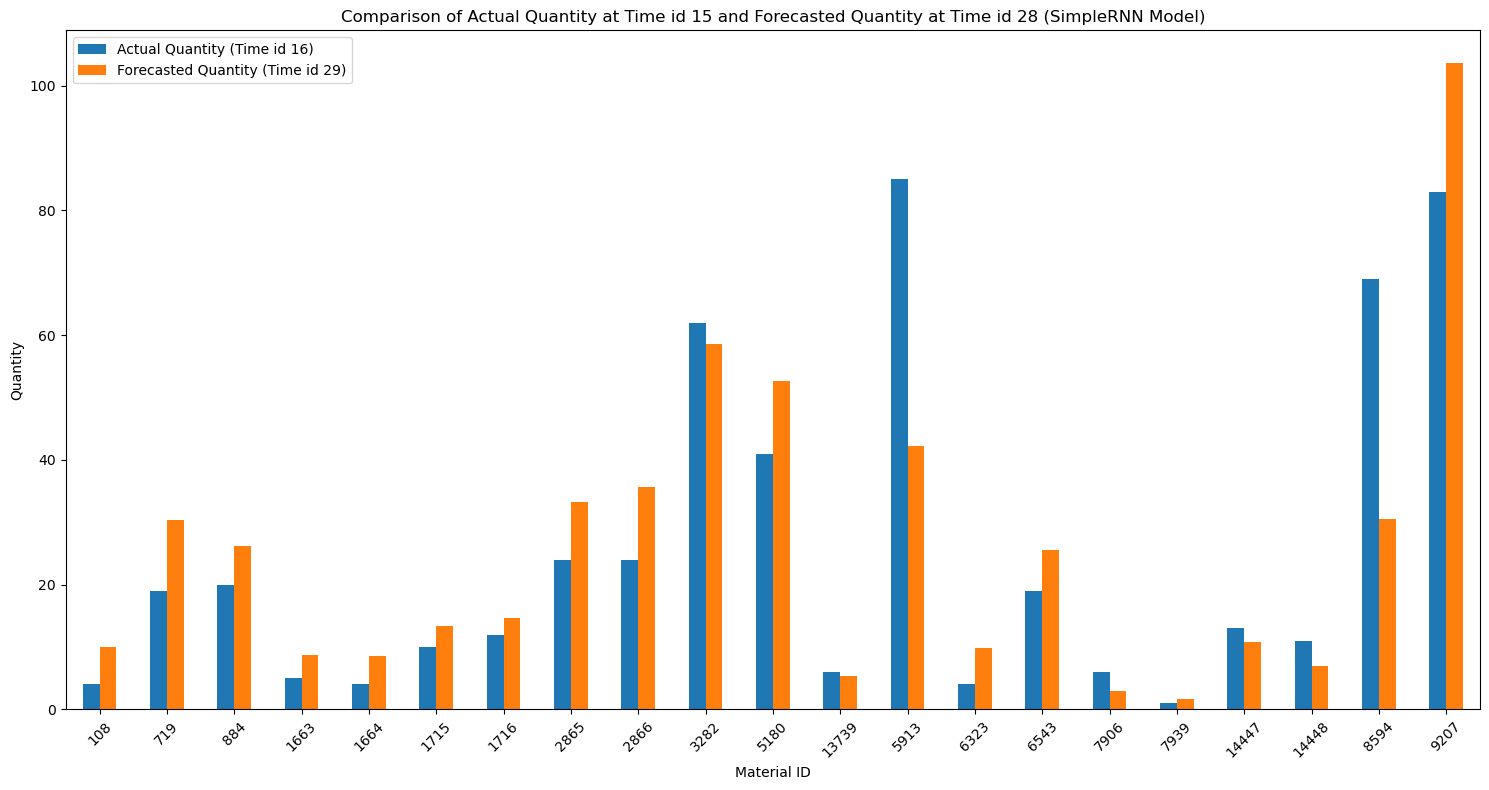

In [5]:
import matplotlib.pyplot as plt

# Filter df for Time id 28
actual_quantities = df[df['Time id'] == 16][['Material_Id', 'Quantity']]
actual_quantities = actual_quantities.set_index('Material_Id')

# Filter forecast_df for Time id 28 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 28) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual and forecasted quantities
merged_df = actual_quantities.join(forecasted_quantities, how='inner', lsuffix='_actual', rsuffix='_forecasted')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 15 and Forecasted Quantity at Time id 28 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 16)', 'Forecasted Quantity (Time id 29)'])
plt.tight_layout()
plt.show()

In [6]:
import matplotlib.pyplot as plt

# Filter df for Time id 16
actual_quantities_16 = df[df['Time id'] == 15][['Material_Id', 'Quantity']]
actual_quantities_16 = actual_quantities_16.set_index('Material_Id')

# Filter df for Time id 28
actual_quantities_28 = df[df['Time id'] == 28][['Material_Id', 'Quantity']]
actual_quantities_28 = actual_quantities_28.set_index('Material_Id')

# Filter forecast_df for Time id 28 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 28) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual quantities at Time id 16, Time id 28, and forecasted quantities
merged_df = actual_quantities_16.join(actual_quantities_28, how='inner', lsuffix='_actual_16', rsuffix='_actual_28')
merged_df = merged_df.join(forecasted_quantities, how='inner')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 16, Actual Quantity at Time id 28, and Forecasted Quantity at Time id 28 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 16)', 'Actual Quantity (Time id 28)', 'Forecasted Quantity (Time id 28)'])
plt.tight_layout()
plt.show()


NameError: name 'actual_quantities_15' is not defined